# Defining adjacency

The key in toplogical coloring is the definition of adjacency, to understand which features are neighboring and could not share the same color. `greedy` comes with several methods of defining it. Binary spatial weights denoting adjacency are then stored as libpysal's weight objects.

In [77]:
import geopandas as gpd
import pandas as pd
import numpy as np
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point

from greedy import greedy

sns.set()

For illustration purposes, let's generate a 10x10 mesh of squared polygons:

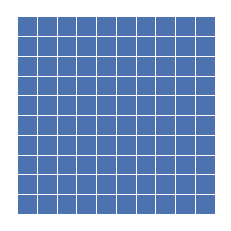

In [78]:
polys = []
for x in range(10):
    for y in range(10):
        polys.append(Point(x, y).buffer(0.5, cap_style=3))
gdf = gpd.GeoDataFrame(geometry=polys)
ax = gdf.plot(edgecolor='w')
ax.set_axis_off()

## libpysal adjacency

The most performant way of generating spatial weights is using libpysal contiguity weights. As they are based on the shared nodes or edges, dataset needs to be topologically correct. Neighboring polygons needs to share vertices and edges, otherwise their relationship will not be captured.

### Rook

There are two ways how to define contiguity weights - `rook` and `queen`. Rook identifies two objects as neighboring only if they share at least on edge - line between two shared points. Use rook if you do not mind two polygons touching by hteir corners having the same color:

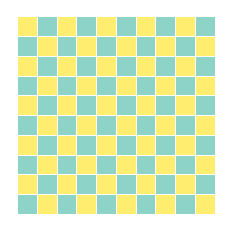

In [52]:
gdf['rook'] = greedy(gdf, sw='rook', min_colors=2)
ax = gdf.plot('rook', edgecolor='w', categorical=True, cmap='Set3')
ax.set_axis_off()

### Queen

The default option in `greedy` is `queen` adjacency. That identifies two objects as neighboring if they share at least one point. It ensures that even poygons sharing only one corner will not share a color:

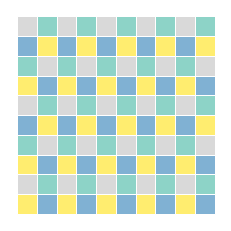

In [53]:
gdf['queen'] = greedy(gdf, sw='queen', min_colors=2)
ax = gdf.plot('queen', edgecolor='w', categorical=True, cmap='Set3')
ax.set_axis_off()

## Intersection-based adjacency

As noted above, if the topology of the dataset is not ideal, libpysal might not identify two visually neighboring features as neighbors. `greedy` can use intersection-based algorithm using GEOS intersection to define if two features intersects in any way. They do not have to share any points. Naturally, such an approach is significantly slower (details below), but it can provide correct adjacency when libpysal fails.

To make `greedy` to use this algorithm, one just needs to define `min_distance`. If it is set to 0, it behaves similarly to `queen` contiguity, just capturing all intersections:

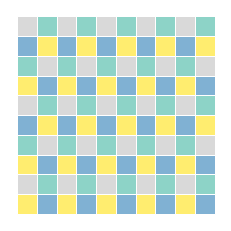

In [54]:
gdf['geos'] = greedy(gdf, min_distance=0, min_colors=2)
ax = gdf.plot('geos', edgecolor='w', categorical=True, cmap='Set3')
ax.set_axis_off()

`min_distance` also sets the minimal distance between colors. To do that, all features within such a distance are identified as neighbors, hence no two features wihtin set distance can share the same color:

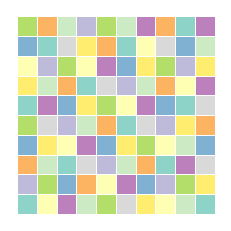

In [55]:
gdf['dist1'] = greedy(gdf, min_distance=1, min_colors=2)
ax = gdf.plot('dist1', edgecolor='w', categorical=True, cmap='Set3')
ax.set_axis_off()

## Reusing spatial weights

Passing `libpysal.weights.W` object to `sw`, will skip generating spatial weights and use the passed object instead. That will improve the performance if one intends to repeate the coloring multiple times. In that case, weights should be denoted using GeodataFrame's index.

## Performance

The difference in performance of libpysal and GEOS-based method is large, so it is recommended to use libpysal if possible. Details of comparison between all methods are below:

In [83]:
times = pd.DataFrame(index=['rook', 'queen', 'geos', 'dist1'])
for number in range(10, 110, 10):
    print(number)
    polys = []
    for x in range(number):
        for y in range(number):
            polys.append(Point(x, y).buffer(0.5, cap_style=3))
    gdf = gpd.GeoDataFrame(geometry=polys)
    timer = []
    for run in range(5):
        s = time()
        colors = greedy(gdf, sw='rook', min_colors=2)
        e = time() - s
        timer.append(e)
    times.loc['rook', number] = np.mean(timer)
    print('rook: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')
    timer = []
    for run in range(5):
        s = time()
        colors = greedy(gdf, sw='queen', min_colors=2)
        e = time() - s
        timer.append(e)
    times.loc['queen', number] = np.mean(timer)
    print('queen: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')
    timer = []
    for run in range(5):
        s = time()
        colors = greedy(gdf, min_distance=0, min_colors=2)
        e = time() - s
        timer.append(e)
    times.loc['geos', number] = np.mean(timer)
    print('geos: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')
    timer = []
    for run in range(5):
        s = time()
        colors = greedy(gdf, min_distance=1, min_colors=2)
        e = time() - s
        timer.append(e)
    times.loc['dist1', number] = np.mean(timer)
    print('dist1: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')


10
rook:  0.008332633972167968 s;  2 colors
queen:  0.0067865848541259766 s;  4 colors
geos:  0.18540759086608888 s;  4 colors
dist1:  0.3216702938079834 s;  10 colors
20
rook:  0.023499011993408203 s;  2 colors
queen:  0.02506265640258789 s;  4 colors
geos:  0.7820498943328857 s;  4 colors
dist1:  1.1883579730987548 s;  10 colors
30
rook:  0.09070181846618652 s;  2 colors
queen:  0.05646052360534668 s;  4 colors
geos:  1.4737992763519288 s;  4 colors
dist1:  2.313761281967163 s;  10 colors
40
rook:  0.1293130874633789 s;  2 colors
queen:  0.08214569091796875 s;  4 colors
geos:  2.6077350616455077 s;  4 colors
dist1:  4.236755275726319 s;  10 colors
50
rook:  0.1469170093536377 s;  2 colors
queen:  0.16109180450439453 s;  4 colors
geos:  4.08953275680542 s;  4 colors
dist1:  6.589194393157959 s;  10 colors
60
rook:  0.25732903480529784 s;  2 colors
queen:  0.25914812088012695 s;  4 colors
geos:  7.026346206665039 s;  4 colors
dist1:  10.011457777023315 s;  10 colors
70
rook:  0.2917982

Comparison of time needed to generate greedy coloring using each of the methods above shows the big difference between GEOS and libpysal:

([<matplotlib.axis.XTick at 0x11fee53d0>,
 <a list of 10 Text xticklabel objects>)

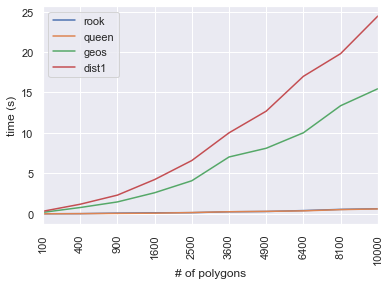

In [84]:
ax = times.T.plot()
ax.set_ylabel('time (s)')
ax.set_xlabel('# of polygons')
locs, labels = plt.xticks()
plt.xticks(locs, (times.columns ** 2), rotation='vertical')

Plotting without the GEOS methods, the difference between `queen` and `rook` is minimal:

([<matplotlib.axis.XTick at 0x122c90f10>,
 <a list of 10 Text xticklabel objects>)

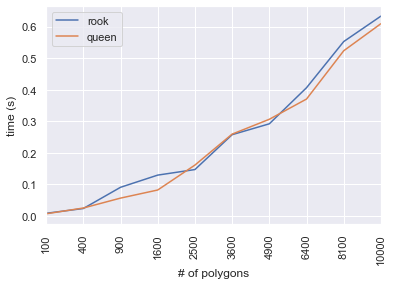

In [85]:
ax = times.loc[['rook', 'queen']].T.plot()
ax.set_ylabel('time (s)')
ax.set_xlabel('# of polygons')
locs, labels = plt.xticks()
plt.xticks(locs, (times.columns ** 2), rotation='vertical')